In [4]:
import sys
from pathlib import Path
import os

ROOT_DIR = Path(os.getcwd()).resolve().parent
if (ROOT_DIR / "networks").exists():
    sys.path.append(str(ROOT_DIR))
else:
    raise FileNotFoundError("Root directory does not contain expected structure. Please adjust ROOT_DIR.")

In [5]:
# Standard library imports
import os
import re
import pickle
import random
from itertools import zip_longest

# Data handling and numerical processing
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt

# Machine learning and data processing libraries
import torch
from scipy.stats import ttest_ind, stats
from tqdm import tqdm

# Custom utilities and feature processing
import src.utils as utils
from pycytominer.operations.transform import RobustMAD
from pycytominer import feature_select

/opt/miniconda3/envs/FeatureAggregation/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [6]:
# Define output dir
output_dir = Path.cwd().parents[0] / "results"

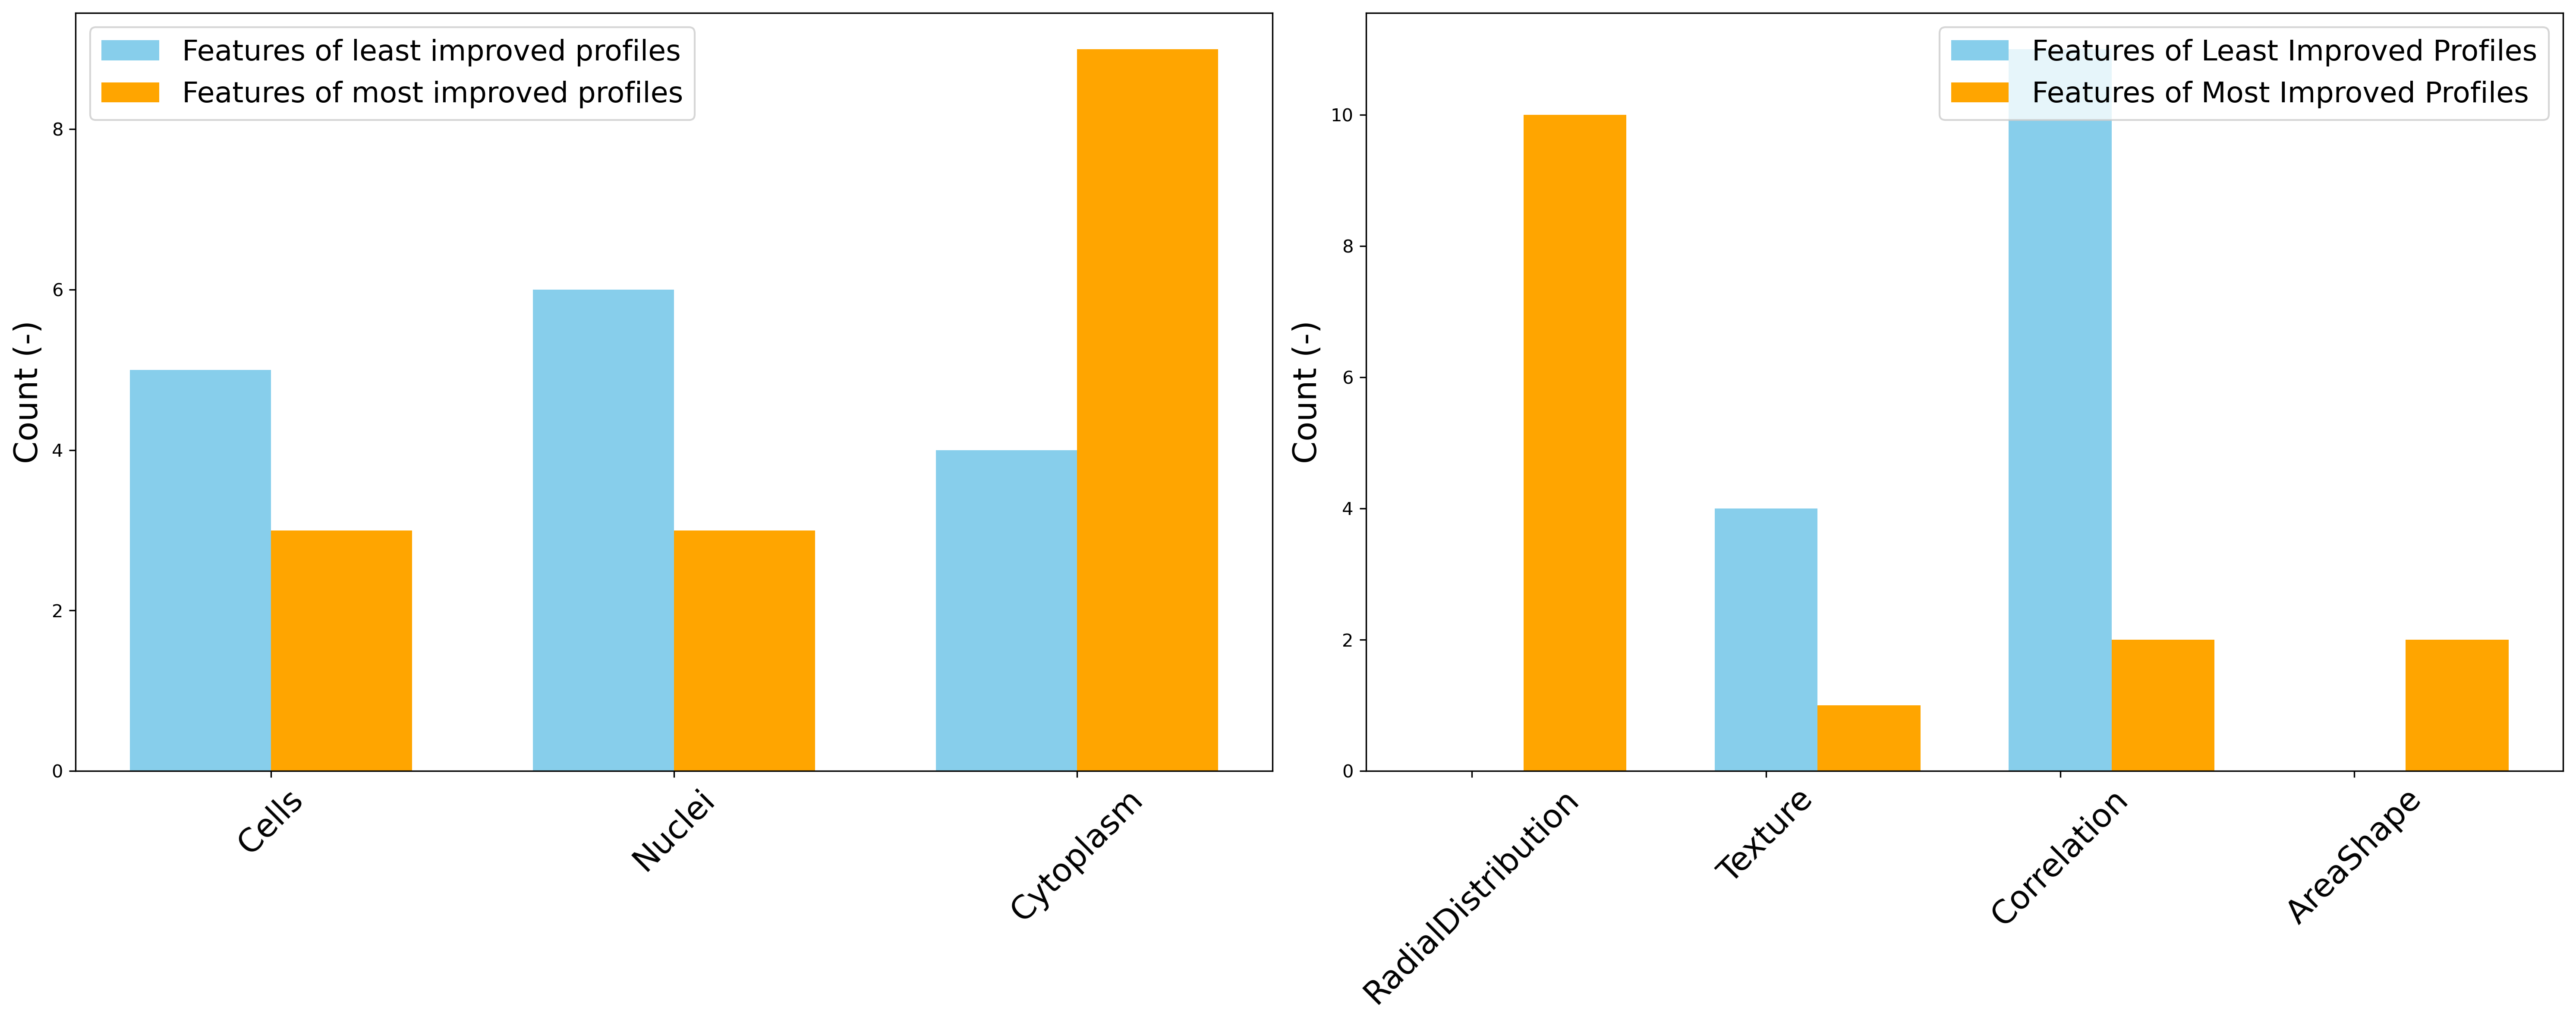

In [7]:
# Least improved features
least_improved_features = [
    "Cytoplasm_Correlation_Costes_RNA_Brightfield",
    "Nuclei_Correlation_Manders_Brightfield_AGP",
    "Nuclei_Correlation_Manders_DNA_AGP",
    "Cells_Correlation_Costes_AGP_Brightfield",
    "Nuclei_Correlation_Costes_Brightfield_AGP",
    "Cytoplasm_Correlation_Costes_ER_Brightfield",
    "Cells_Correlation_Costes_Brightfield_ER",
    "Nuclei_Correlation_Costes_DNA_Brightfield",
    "Cells_Correlation_Costes_Brightfield_Mito",
    "Nuclei_Correlation_Costes_Brightfield_DNA",
    "Cells_Texture_InfoMeas2_ER_20_01",
    "Cytoplasm_Texture_InfoMeas2_ER_20_00",
    "Cytoplasm_Texture_InfoMeas2_ER_20_02",
    "Cells_Texture_InfoMeas2_ER_20_03",
    "Nuclei_Correlation_Manders_Brightfield_AGP"
]

# Most improved features
most_improved_features = [
    "Cytoplasm_RadialDistribution_RadialCV_Mito_3of4",
    "Cells_RadialDistribution_RadialCV_Mito_4of4",
    "Cytoplasm_RadialDistribution_RadialCV_Mito_2of4",
    "Cells_Correlation_Overlap_Mito_Brightfield",
    "Cytoplasm_Correlation_Overlap_Mito_Brightfield",
    "Nuclei_AreaShape_Zernike_2_0",
    "Nuclei_Texture_InverseDifferenceMoment_Brightfield_5_00",
    "Cytoplasm_RadialDistribution_FracAtD_Mito_2of4",
    "Cytoplasm_RadialDistribution_FracAtD_Mito_1of4",
    "Nuclei_AreaShape_Zernike_5_3",
    "Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4",
    "Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4",
    "Cytoplasm_RadialDistribution_FracAtD_RNA_2of4",
    "Cells_RadialDistribution_RadialCV_RNA_2of4",
    "Cytoplasm_RadialDistribution_FracAtD_RNA_1of4"
]

# Initialize defaultdicts to count feature types and measurement types
feature_counts_least_improved = defaultdict(int)
measurement_counts_least_improved = defaultdict(int)
feature_counts_most_improved = defaultdict(int)
measurement_counts_most_improved = defaultdict(int)

# Count occurrences of each feature type and measurement type for least improved features
for feature in least_improved_features:
    feature_type, measurement_type = feature.split('_')[:2]
    feature_counts_least_improved[feature_type] += 1
    measurement_counts_least_improved[measurement_type] += 1

# Count occurrences of each feature type and measurement type for most improved features
for feature in most_improved_features:
    feature_type, measurement_type = feature.split('_')[:2]
    feature_counts_most_improved[feature_type] += 1
    measurement_counts_most_improved[measurement_type] += 1

# Get feature types and counts for plotting
feature_types = list(set(feature_counts_least_improved.keys()) | set(feature_counts_most_improved.keys()))
counts_least_improved = [feature_counts_least_improved[feature_type] for feature_type in feature_types]
counts_most_improved = [feature_counts_most_improved[feature_type] for feature_type in feature_types]

# Get measurement types and counts for plotting
measurement_types = list(set(measurement_counts_least_improved.keys()) | set(measurement_counts_most_improved.keys()))
counts_measurement_least_improved = [measurement_counts_least_improved[measurement_type] for measurement_type in measurement_types]
counts_measurement_most_improved = [measurement_counts_most_improved[measurement_type] for measurement_type in measurement_types]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(feature_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, axs = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
fs = 18

# Plot the bar chart for feature types
axs[0].bar(r1, counts_least_improved, color='skyblue', width=bar_width, label='Features of least improved profiles')
axs[0].bar(r2, counts_most_improved, color='orange', width=bar_width, label='Features of most improved profiles')
axs[0].set_ylabel('Count (-)', fontsize=fs)
axs[0].set_xticks([r + bar_width/2 for r in range(len(feature_types))])
axs[0].set_xticklabels(feature_types, rotation=45, fontsize=fs)
axs[0].legend(loc='upper left', fontsize=fs-2)

# Set the positions of the bars on the x-axis
r1 = np.arange(len(measurement_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bar chart for measurement types
axs[1].bar(r1, counts_measurement_least_improved, color='skyblue', width=bar_width, label='Features of Least Improved Profiles')
axs[1].bar(r2, counts_measurement_most_improved, color='orange', width=bar_width, label='Features of Most Improved Profiles')
axs[1].set_ylabel('Count (-)', fontsize=fs)  # Adjust fontsize for the y-axis label
axs[1].set_xticks(range(len(measurement_types)))
axs[1].set_xticklabels(measurement_types, rotation=45, fontsize=fs)  # Adjust fontsize for x-axis tick labels
axs[1].legend(loc='upper right', fontsize=fs-2) 

plt.tight_layout()
plt.savefig(os.path.join("Figures", 'S1FigI.png'), dpi=450)
plt.show()